# Titanic prediction

Keras 入門題目，鐵達尼生存預測  
當作基本的classifier練習

[Titanic competition link](https://www.kaggle.com/c/titanic)




## Step1. 資料載入  
首先把資料集利用pandas抓近來觀察  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows',10)  

root = os.getcwd()
train_path = os.path.join(root,'titanic/train.csv')
test_path = os.path.join(root,'titanic/test.csv')

train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)

train_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


## 資料描述

![](https://i.imgur.com/wYq0bGy.jpg)


這個訓練樣本數不多，只有900筆而已  
把訓練樣本與測試樣本合併，作為觀察與處理  

In [3]:
train_data['test_data'] = 0
test_data['test_data'] = 1
data = train_data.append(test_data,ignore_index=True,sort=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
Age            1046 non-null float64
Cabin          295 non-null object
Embarked       1307 non-null object
Fare           1308 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
test_data      1309 non-null int64
dtypes: float64(3), int64(5), object(5)
memory usage: 133.0+ KB


## Step2. 特徵觀察

Deep Learning的訓練結果好壞取決於特徵的選取  
使否有過冗的參數，或是無用的參數，與好的參數留取都是會影響到訓練的結果  
在補上空白值的參數也是提升訓練結果的重要步驟  

需要觀察資料來確認特徵關聯性來決定資料的處理

### 觀察生還與死亡

大約4成的人生存，可以用一般的logistic regresssion來做分類

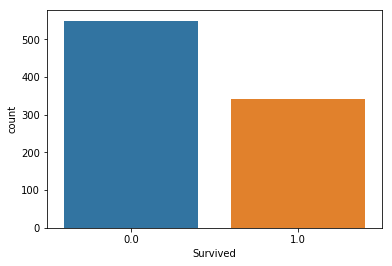

In [4]:
%matplotlib inline
sns.countplot(data['Survived'])

### 觀察性別與生存關係 Sex  

女性生存的機率較高

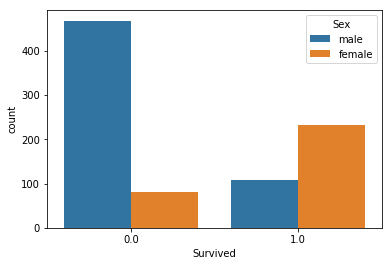

In [5]:
sns.countplot(data['Survived'],hue=data['Sex'])

### 艙等與生存率關係 Pclass
  
三等艙的死亡率較高，二等艙機率持平，一等艙生還率超過死亡率

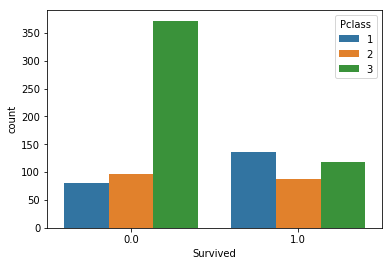

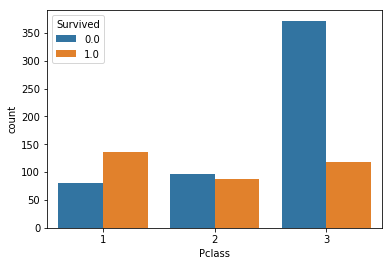

In [6]:
sns.countplot(data['Survived'],hue=data['Pclass'])
plt.figure()
sns.countplot(data['Pclass'],hue=data['Survived'])

### 家庭成員關係 SibSp & Parch

可以看到單身的人其死亡率較高，在有家庭成員下的死亡率趨近於相等
但是觀察性別在單身與否的狀況下發現其結果與觀察死亡性很像

藉由畫出組合的結果，可以發現在單身下，死亡的幾乎為男性
所以家庭成員這項要素可以視為冗餘的參數，暫時不需考慮進模型

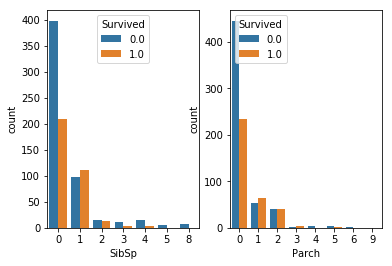

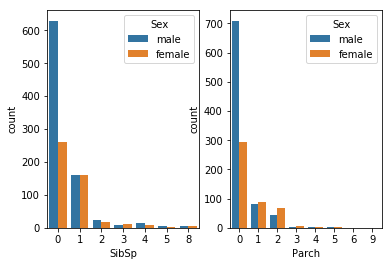

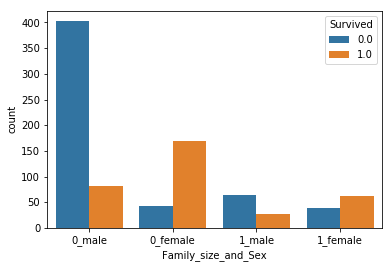

In [7]:
fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Survived'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Survived'],ax=ax2)


fig, [ax1,ax2] = plt.subplots(1,2)
sns.countplot(data['SibSp'],hue=data['Sex'],ax=ax1)
sns.countplot(data['Parch'],hue=data['Sex'],ax=ax2)


data['Family_size_and_Sex'] = (data['Parch']+data['SibSp']).map(lambda x : 1 if x >1 else 0).astype('str')+'_'+data['Sex']


plt.figure()
sns.countplot(data['Family_size_and_Sex'],hue=data['Survived'])

### 年齡關係 Age

可以觀察到年齡較輕者在生存率上較高

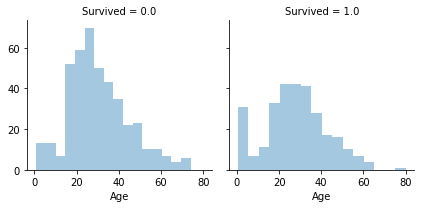

In [8]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Age',kde=False)

### 票價 Fare

可以票價價低者的死亡率較高

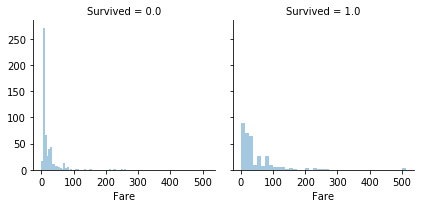

In [9]:
g= sns.FacetGrid(data,col='Survived')
g.map(sns.distplot,'Fare',kde=False)

有一筆缺失值，補上平均數就好  

In [10]:
data.Fare = data.Fare.apply(lambda x: data.Fare.mean() if pd.isnull(x) else x)

### 乘船處 Embarked

乘船處對於死亡率的分布也是有關係的  
但是進一步把每個港口的上船性別分布拆開來看  
其實港口的差別只是因為性別關係帶來的影響  
可以視作這是一個冗餘的參數

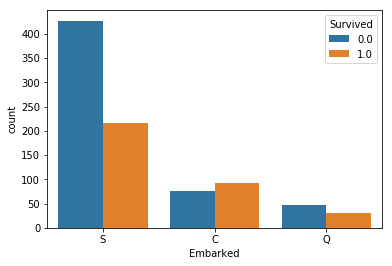

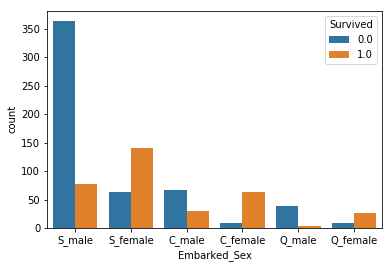

In [11]:
sns.countplot(data['Embarked'],hue=data['Survived'])

data['Embarked_Sex'] = data['Embarked']+'_'+data['Sex']
plt.figure()
sns.countplot(data['Embarked_Sex'],hue=data['Survived'], order=['S_male','S_female','C_male','C_female','Q_male','Q_female'])

### 票等 Pclass
票等在第三艙等也是有較高的死亡率  
進一步分析看看是否又是性別帶出來的結果  
發現在各個票等間，每個性別生存的比例不一樣  

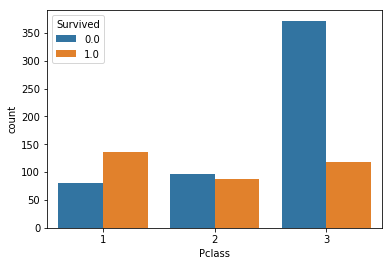

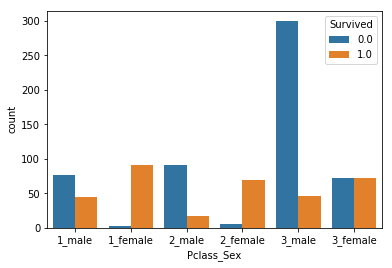

In [12]:
sns.countplot(data['Pclass'],hue=data['Survived'])
data['Pclass_Sex'] = data['Pclass'].astype('str')+'_'+data['Sex']

plt.figure()
sns.countplot(data['Pclass_Sex'],hue=data['Survived'], order=['1_male','1_female','2_male','2_female','3_male','3_female'])

### 艙等 Cabin
艙等的生存分布與性別分布呈現強相關  
而性別的分布又會是生存率分布的強烈因子  
判定這個參數是多餘的  

['NoCabin' 'C' 'E' 'G' 'D' 'A' 'B' 'F' 'T']


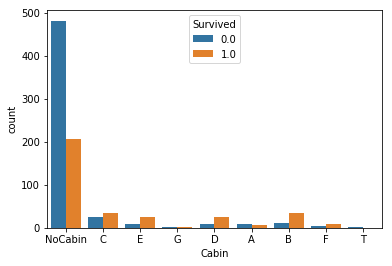

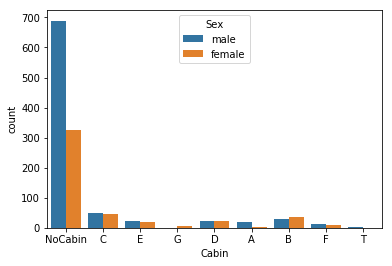

In [13]:
data['Cabin'] = data['Cabin'].apply(lambda x: str(x)[0] if not pd.isnull(x) else 'NoCabin')
print(data['Cabin'].unique())

sns.countplot(data['Cabin'],hue=data['Survived'])
plt.figure()
sns.countplot(data['Cabin'],hue=data['Sex'])

### 姓名 Name

姓名欄內都會有稱謂  
我們知道稱謂與年齡有相關性
因此我們利用稱謂來填補年齡

In [14]:
data['Title']=data['Name'].str.split(', ',n=0,expand=True)[1]
data['Title']=data['Title'].str.split('. ',n=0,expand=True)[0]
map_of_age = dict(data.groupby(['Title'])['Age'].median())
map_of_age

{'Capt': 70.0,
 'Col': 54.5,
 'Don': 40.0,
 'Dona': 39.0,
 'Dr': 49.0,
 'Jonkheer': 38.0,
 'Lady': 48.0,
 'Major': 48.5,
 'Master': 4.0,
 'Miss': 22.0,
 'Mlle': 24.0,
 'Mme': 24.0,
 'Mr': 29.0,
 'Mrs': 35.5,
 'Ms': 28.0,
 'Rev': 41.5,
 'Sir': 49.0,
 'th': 33.0}

In [15]:
for i in range(len(data['Age'])):
    if data.Age.isnull()[i]:
        data.Age[i]=map_of_age[data.Title[i]]


C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


### 票根 Ticket

收先觀察Ticket內容  
可以發現有一部分票的內容是重複的  

In [16]:
data['Ticket'].describe()

count         1309
unique         929
top       CA. 2343
freq            11
Name: Ticket, dtype: object

In [17]:
count_of_ticket = dict(data.groupby(['Ticket'])['Ticket'].count())

In [19]:
data['Ticket_group']=0
for i in range(len(data['Ticket'])):
    if count_of_ticket[data.Ticket[i]]>3 and (data.SibSp[i]+data.Parch[i])>3:
        data.Ticket_group[i]=1

C:\Users\a2720\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Ticket_group
0    1232
1      77
Name: Ticket_group, dtype: int64

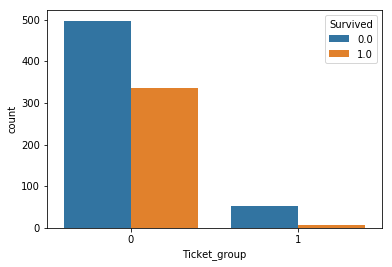

In [20]:
sns.countplot(data['Ticket_group'],hue=data['Survived'])
data.groupby(['Ticket_group'])['Ticket_group'].count()

## Step3. 資料預處理

資料的處理有兩個處理方法  
其一是one hot encoding，如果資料為無序的，就會利用此方法對資料做編碼  
來把資料轉換維n維向量，讓其數據與原點的距離一致。  
  
另一個方法是當資料是有序的時候，直接數值化mapping資料  
讓每筆資料以一個數字表示，這會讓資料與原點距離不同。

把特徵工程觀察的結果處理在我們的資料集上

以下是處理過的原始資料  
要把他轉換成model吃的資料

In [21]:
data.head(10)

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,test_data,Family_size_and_Sex,Embarked_Sex,Pclass_Sex,Title,Ticket_group
0,22.0,NoCabin,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,0_male,S_male,3_male,Mr,0
1,38.0,C,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,0_female,C_female,1_female,Mrs,0
2,26.0,NoCabin,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,0,0_female,S_female,3_female,Miss,0
3,35.0,C,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,0_female,S_female,1_female,Mrs,0
4,35.0,NoCabin,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,0,0_male,S_male,3_male,Mr,0
5,29.0,NoCabin,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877,0,0_male,Q_male,3_male,Mr,0
6,54.0,E,S,51.8625,"McCarthy, Mr. Timothy J",0,7,1,male,0,0.0,17463,0,0_male,S_male,1_male,Mr,0
7,2.0,NoCabin,S,21.0750,"Palsson, Master. Gosta Leonard",1,8,3,male,3,0.0,349909,0,1_male,S_male,3_male,Master,1
8,27.0,NoCabin,S,11.1333,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",2,9,3,female,0,1.0,347742,0,1_female,S_female,3_female,Mrs,0
9,14.0,NoCabin,C,30.0708,"Nasser, Mrs. Nicholas (Adele Achem)",0,10,2,female,1,1.0,237736,0,0_female,C_female,2_female,Mrs,0


In [22]:
train_data = data[data['test_data']==0].iloc[:,0:12]
test_data = data[data['test_data']==1].iloc[:,0:12]

In [23]:
train_data_label = train_data.Survived

train_data = train_data.drop(['Name','Cabin','Embarked','PassengerId','SibSp','Parch','Survived','Ticket'],axis=1)
test_data = test_data.drop(['Name','Cabin','Embarked','PassengerId','SibSp','Parch','Survived','Ticket'],axis=1)

### one_hot_encoding

pandas有很方便的函數  get_dummies  
可以簡單的幫助資料型態轉成one hot的形式  

In [24]:
def one_hot(data, col):
    temp = pd.get_dummies(data[col],prefix=col)
    data = data.drop([col],axis=1)
    data = pd.concat([data,temp],axis=1)
    return data

把sex與pclass轉成one hot

In [25]:
train_data = one_hot(train_data,'Sex')
train_data = one_hot(train_data,'Pclass')
test_data = one_hot(test_data,'Sex')
test_data = one_hot(test_data,'Pclass')

把ticket group也加入

In [26]:
train_data=pd.concat([train_data,data.Ticket_group],axis=1).dropna()
test_data=pd.concat([test_data,data.Ticket_group],axis=1).dropna()
train_data

,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Ticket_group
0,22.0,7.2500,0.0,1.0,0.0,0.0,1.0,0
1,38.0,71.2833,1.0,0.0,1.0,0.0,0.0,0
2,26.0,7.9250,1.0,0.0,0.0,0.0,1.0,0
3,35.0,53.1000,1.0,0.0,1.0,0.0,0.0,0
4,35.0,8.0500,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
886,27.0,13.0000,0.0,1.0,0.0,1.0,0.0,0
887,19.0,30.0000,1.0,0.0,1.0,0.0,0.0,0
888,22.0,23.4500,1.0,0.0,0.0,0.0,1.0,0
889,26.0,30.0000,0.0,1.0,1.0,0.0,0.0,0


### normalization

在Deep Learning上，需要把資料縮放到[0,1] 區間  
否則在該參數的梯度下降會被拖累  

In [27]:
def normalization(data, col):
    data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
    return data

In [28]:
train_data = normalization(train_data, 'Age')
train_data = normalization(train_data, 'Fare')
test_data = normalization(test_data, 'Age')
test_data = normalization(test_data, 'Fare')

In [29]:
train_data.astype('float32')
test_data.astype('float32')

,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Ticket_group
891,0.452723,0.015282,0.0,1.0,0.0,0.0,1.0,0.0
892,0.617566,0.013663,1.0,0.0,0.0,0.0,1.0,0.0
893,0.815377,0.018909,0.0,1.0,0.0,1.0,0.0,0.0
894,0.353818,0.016908,0.0,1.0,0.0,0.0,1.0,0.0
895,0.287881,0.023984,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
1304,0.380193,0.015713,0.0,1.0,0.0,0.0,1.0,0.0
1305,0.512066,0.212559,1.0,0.0,1.0,0.0,0.0,0.0
1306,0.505473,0.014151,0.0,1.0,0.0,0.0,1.0,0.0
1307,0.380193,0.015713,0.0,1.0,0.0,0.0,1.0,0.0


In [31]:
test_data.info()

train_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 891 to 1308
Data columns (total 8 columns):
Age             418 non-null float64
Fare            418 non-null float64
Sex_female      418 non-null float64
Sex_male        418 non-null float64
Pclass_1        418 non-null float64
Pclass_2        418 non-null float64
Pclass_3        418 non-null float64
Ticket_group    418 non-null int64
dtypes: float64(7), int64(1)
memory usage: 29.4 KB


,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Ticket_group
0,0.271174,0.014151,0.0,1.0,0.0,0.0,1.0,0
1,0.472229,0.139136,1.0,0.0,1.0,0.0,0.0,0
2,0.321438,0.015469,1.0,0.0,0.0,0.0,1.0,0
3,0.434531,0.103644,1.0,0.0,1.0,0.0,0.0,0
4,0.434531,0.015713,0.0,1.0,0.0,0.0,1.0,0
...,...,...,...,...,...,...,...,...
886,0.334004,0.025374,0.0,1.0,0.0,1.0,0.0,0
887,0.233476,0.058556,1.0,0.0,1.0,0.0,0.0,0
888,0.271174,0.045771,1.0,0.0,0.0,0.0,1.0,0
889,0.321438,0.058556,0.0,1.0,1.0,0.0,0.0,0


## Step4. 訓練模型

使用Keras來創建模型  
這裡利用全連結層做11層，最後接上sigmoid利用binary crossentropy做loss function來輸出  

In [36]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

model.add(Dense(units=128,input_dim=train_data.shape[1],activation='relu',kernel_initializer='normal'))
#model.add(Dropout(0.3))

for _ in range(5):
    model.add(Dense(units=128,activation='relu',kernel_initializer='normal'))
    #model.add(Dropout(0.3))

model.add(Dense(units=1,activation='sigmoid',kernel_initializer='normal'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 129       
Total para

這裡挑batch_size=100,訓練500次  

In [37]:
model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

train_history= model.fit(x=train_data.values,y=train_data_label,validation_split=0.2,batch_size=50,epochs=100,verbose=2)

Train on 712 samples, validate on 179 samples
Epoch 1/100
 - 0s - loss: 0.6827 - acc: 0.6222 - val_loss: 0.6323 - val_acc: 0.8101
Epoch 2/100
 - 0s - loss: 0.5538 - acc: 0.7851 - val_loss: 0.4484 - val_acc: 0.8268
Epoch 3/100
 - 0s - loss: 0.4835 - acc: 0.7935 - val_loss: 0.4261 - val_acc: 0.8045
Epoch 4/100
 - 0s - loss: 0.4461 - acc: 0.7978 - val_loss: 0.3949 - val_acc: 0.8324
Epoch 5/100
 - 0s - loss: 0.4503 - acc: 0.8188 - val_loss: 0.4078 - val_acc: 0.8212
Epoch 6/100
 - 0s - loss: 0.4466 - acc: 0.7879 - val_loss: 0.3964 - val_acc: 0.8324
Epoch 7/100
 - 0s - loss: 0.4364 - acc: 0.8090 - val_loss: 0.3807 - val_acc: 0.8324
Epoch 8/100
 - 0s - loss: 0.4419 - acc: 0.8076 - val_loss: 0.3793 - val_acc: 0.8380
Epoch 9/100
 - 0s - loss: 0.4327 - acc: 0.8034 - val_loss: 0.3759 - val_acc: 0.8380
Epoch 10/100
 - 0s - loss: 0.4282 - acc: 0.8118 - val_loss: 0.3838 - val_acc: 0.8324
Epoch 11/100
 - 0s - loss: 0.4329 - acc: 0.8104 - val_loss: 0.3689 - val_acc: 0.8324
Epoch 12/100
 - 0s - loss: 0

Epoch 97/100
 - 0s - loss: 0.3974 - acc: 0.8244 - val_loss: 0.3060 - val_acc: 0.8771
Epoch 98/100
 - 0s - loss: 0.4064 - acc: 0.8216 - val_loss: 0.3436 - val_acc: 0.8659
Epoch 99/100
 - 0s - loss: 0.3959 - acc: 0.8244 - val_loss: 0.3301 - val_acc: 0.8603
Epoch 100/100
 - 0s - loss: 0.3904 - acc: 0.8287 - val_loss: 0.3145 - val_acc: 0.8603


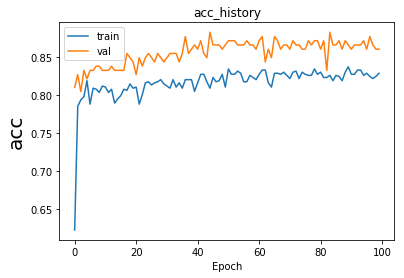

<Figure size 432x288 with 0 Axes>

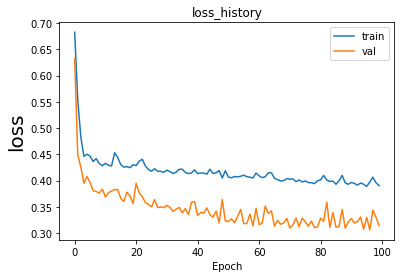

In [38]:
import matplotlib.pyplot as plt

def plot_train_result(train_history,train,val):
    plt.figure()
    plt.plot(train_history.history[train],label='train')
    plt.plot(train_history.history[val],label='val')
    plt.title(train+'_history')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylabel(train,fontsize=20)
    plt.show()

    

plot_train_result(train_history,'acc','val_acc')
plt.figure()
plot_train_result(train_history,'loss','val_loss')

## Step5. 儲存結果上傳

In [39]:
result = model.predict_classes(test_data.values)
sub = pd.DataFrame()
sub['PassengerId'] = test_data.index+1
sub['Survived'] = result

sub.shape

(418, 2)

In [40]:
sub.to_csv('titanic_keras_cs3.csv', index=False)

可以在Kaggle上觀看自己的結果  
我的模型得到了79.9%的準確率  
大約是1647/11006~15%的名次

![](https://i.imgur.com/9Jt84qH.png)